# IMDB dataset from Deep Learning with Python (Manning book)

This is learning Keras directly taking the IMDB data set from keras, and sorting it out in various ways.

First we may need to set it up to possibly switch from GPU to CPU, I ran into a problem where my GPU ran out of memory sometimes, so switching to CPU isn't ideal, but it's better than no compute at all.
   

In [1]:
# Uncomment below this line if you need to turn on CPU. Comment it out again if you want GPU
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Loading IMDB dataset 

First we have to load the IMDB data set from the keras library. If we want to see the actual words, uncomment and print out the second section in the code below.

In [2]:
# load IMDB dataset in keras
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

# if we want to see what the actual words are, uncomment this and use this code
# word_index = imdb.get_word_index()
# reverse_word_index = dict([(value, key) for (key,value) in word_index.items()])
# decoded_review = ' '.join(reverse_word_index.get(i - 3, '?') for i in train_data[0])

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
c:\users\hobbes\source\repos\kerasmltutorialfromdeeplearningwithpython\venv\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
c:\users\hobbes\source\repos\kerasmltutorialfromdeeplearningwithpython\venv\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list

## Prepping the data

There are a few ways to prep the data, because each word is turned into an integer value it can be represented a few ways, for this example we're going to encode the integer sequences into a binary matrix. The location on the matrix, if it's on or off, will represent the word, or words.

In [3]:
# Encode the integer sequences into a binary matrix
import numpy as np


def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results


x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

## Define the model by setting up the layers

For now we'll use .Sequential(), but we can dig in later to more detailed settings using the functional API. Just as an example, here's what these same layers would look like using the functional API: 

```
input_tensor = layers.Input(shape=(784,))
x = layers.Dense(32, activation='relu')(input_tensor)
output_tensor = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs=input_tensor, outputs=output_tensor)
```

In [4]:
from keras import models
from keras import layers

# Define the model by setting up the layers,
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

## Compile the model, and configure the optimizer

Something to note here, the configurations shown below are only if we want to actually dig in to the settings for things like `optimizer`, `loss`, or `metrics`. If we want to use default settings, just use strings like so: 
```
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
```

In [5]:
from keras import optimizers, losses, metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

## Training Validation

Ok so here's something I still need to dig more into, validating the training. Basically you set aside a small portion of your training data to use as validation that the trainin was actually worth anything. The interesting thing though is that this can lead of overoptimization. We'll get more into that in a later section though, but sometimes too many epochs, or certain settings can wind up detrimental to the expected outcome.

In the code below we're going to set aside 10,000 samples for validation

In [6]:
# Set aside samples for monitoring accuracy
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val)
                    )

history_dict = history.history
print('\nHistory Dictionary Keys:', history_dict.keys(), '\n')

Epoch 1/20
30/30 [==============================] - 5s 81ms/step - loss: 0.5862 - binary_accuracy: 0.7205 - val_loss: 0.3930 - val_binary_accuracy: 0.8626
Epoch 2/20
30/30 [==============================] - 1s 28ms/step - loss: 0.3285 - binary_accuracy: 0.8990 - val_loss: 0.3073 - val_binary_accuracy: 0.8884
Epoch 3/20
30/30 [==============================] - 1s 28ms/step - loss: 0.2320 - binary_accuracy: 0.9283 - val_loss: 0.2970 - val_binary_accuracy: 0.8812
Epoch 4/20
30/30 [==============================] - 1s 28ms/step - loss: 0.1781 - binary_accuracy: 0.9427 - val_loss: 0.2820 - val_binary_accuracy: 0.8870
Epoch 5/20
30/30 [==============================] - 1s 28ms/step - loss: 0.1438 - binary_accuracy: 0.9551 - val_loss: 0.2874 - val_binary_accuracy: 0.8882
Epoch 6/20
30/30 [==============================] - 1s 28ms/step - loss: 0.1167 - binary_accuracy: 0.9674 - val_loss: 0.2928 - val_binary_accuracy: 0.8854
Epoch 7/20
30/30 [==============================] - 1s 29ms/step - los

## Plot the training and validation loss

Just so we can get a visual sense of what's actually happening with our training model, let's plot it's loss per epoch over time. 

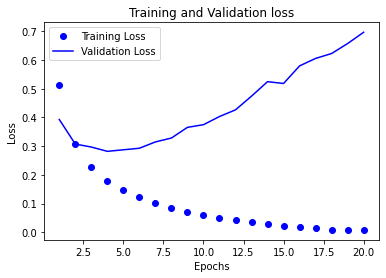

In [7]:
# Plotting the training and validation loss
import matplotlib.pyplot as plt

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['binary_accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Plot the training and validation accuracy

This is where we'll actually see the problem of overoptimizing, giving us less accuracy as the model continues to 'learn'

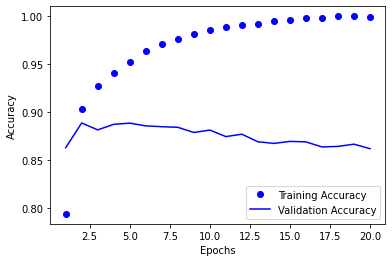

In [8]:
# Plotting the training and validation accuracy
plt.clf()
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Preventing Overoptimization

Because we see a loss in accuracy around the 4th epoch, we'll stop the training at that point so we maximize the optimization. Also as an experiment, we can add layers and mess with the hidden unit settings as well. The original settings are:
```
#Retraining a model from scratch, to see what it looks like to prevent overtraining
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
print('\nResults:', results)
```

Below might look different, just trying out different settings to get a feel for how optimization is affected. 

This may be adding more layers, tweaking the hidden units, using different optimizers or activations.

In [14]:
#Retraining a model from scratch, to see what it looks like to prevent overtraining
model = models.Sequential()
model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=4, batch_size=512)
print('-----')
results = model.evaluate(x_test, y_test)
print('\nResults:', results)

Epoch 1/4
49/49 [==============================] - 2s 20ms/step - loss: 0.6764 - accuracy: 0.6080
Epoch 2/4
49/49 [==============================] - 1s 19ms/step - loss: 0.5834 - accuracy: 0.7713
Epoch 3/4
49/49 [==============================] - 1s 20ms/step - loss: 0.4774 - accuracy: 0.8759 0s - loss: 0.4815 - accuracy: 
Epoch 4/4
49/49 [==============================] - 1s 19ms/step - loss: 0.3641 - accuracy: 0.9053
-----
782/782 [==============================] - 4s 5ms/step - loss: 0.3445 - accuracy: 0.8832

Results: [0.3445233702659607, 0.8831599950790405]
